# Makemore: Part 3
Before we head into the more advanced Neural Networks, let us first learn the ins and outs of backprop in MLPs.

In [2]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# read in all the words
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [4]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [5]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?
def build_dataset(words):
    X, Y = [],[]
    
    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix] # crop and append
    
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int (0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1]) # training, 80%
Xdev, Ydev = build_dataset(words[n1:n2]) # dev/validation, 10% = [n1:n2] = n2 - n1
Xte, Yte = build_dataset(words[n2:]) # test, 10% = [n2:]

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [6]:
neuron_count = 200
embedding_dimension = 10
inputs = embedding_dimension * block_size # because the neural net always takes 3 inputs, so we multiply by 3 for inputs towards the hidden layer

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size,embedding_dimension), generator=g) # 10 dimensional embeddings
W1 = torch.randn((inputs,neuron_count), generator=g)
b1 = torch.randn(neuron_count, generator=g)
W2 = torch.randn((neuron_count,vocab_size), generator=g) * 0.01 # don't set weights to 0
b2 = torch.randn(vocab_size, generator=g) * 0 # adding a random b2 at initilization isn't useful
parameters = [C, W1, b1, W2, b2]

print(sum(p.nelement() for p in parameters)) # number of parameters in total

for p in parameters:
    p.requires_grad = True

11897


In [9]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    # mini batch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
    
    # forward pass
    emb = C[Xtr[ix]]                        # embed the characters into vectors
    embcat = emb.view(emb.shape[0], -1)     # concatenate the vectors
    hpreact = embcat @ W1 + b1              # hidden layer pre-activation
    h = torch.tanh(hpreact)                 # hidden layer
    logits = h @ W2 + b2                    # output layer
    loss = F.cross_entropy(logits, Ytr[ix]) # loss function
    
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

      0/ 200000: 3.1857
  10000/ 200000: 1.8700
  20000/ 200000: 1.9252
  30000/ 200000: 2.0570
  40000/ 200000: 2.2073
  50000/ 200000: 2.1325
  60000/ 200000: 2.1533
  70000/ 200000: 2.8029
  80000/ 200000: 2.6544
  90000/ 200000: 2.2931
 100000/ 200000: 2.2814
 110000/ 200000: 1.8629
 120000/ 200000: 2.1695
 130000/ 200000: 1.9693
 140000/ 200000: 1.8043
 150000/ 200000: 2.4483
 160000/ 200000: 2.2238
 170000/ 200000: 1.7788
 180000/ 200000: 1.9207
 190000/ 200000: 2.1601


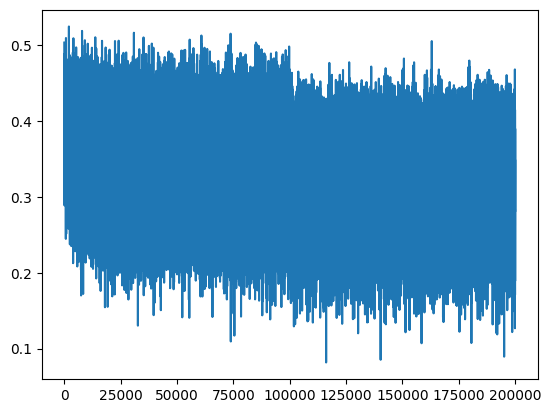

In [10]:
plt.plot(lossi)

In [11]:
@torch.no_grad() # this decorator disables gradient tracking, just makes it more efficient
def split_loss(split):
    x, y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte),
    }[split]
    emb = C[x]                           # (N, block_size, n_embd)
    embcat = emb.view(emb.shape[0], -1)  # concat into (N, block_size, n_embd)
    h = torch.tanh(embcat @ W1 + b1)     # (N, n_hidden)
    logits = h @ W2 + b2                 # (N, vocab_size)
    loss = F.cross_entropy(logits, y) 
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.0695769786834717
val 2.131199598312378


In [12]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    out = []
    context = [0] * block_size
    while True:
        # forward pass the neural net
        emb = C[torch.tensor([context])] # (1, block_size, nembd)
        h = torch.tanh(emb.view(1,-1)@ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        # sample from the distribution
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        # shift the context window and track the samples
        context = context[1:] + [ix]
        out.append(ix)
        # if we sample the special '.' token, break
        if ix == 0:
            break

    print(''.join(itos[i] for i in out))

carman.
amille.
khyrmyn.
reet.
khalayane.
mahnen.
deliah.
jareei.
nellara.
chaiivon.
legen.
ham.
jorn.
quintin.
lilea.
jadiquinterri.
jarysia.
kael.
dustine.
deciia.


## Initialization
We can tell that our network is improperly intialized, since our initial loss is a staggering 27.8, which then rapidly comes down to 2.

In training Neural Nets, there is always the rough idea of what you can expect the initial loss is at initialization. In our case, calculating the intial loss is simple.

We have 27 random characters to chose from, each of which should be uniform in probability. Thus, we have a $\dfrac{1}{27}$ probability.

To calculate the loss, recall that we use the negative log likelihood.

In [13]:
-torch.tensor(1/27.0).log()

tensor(3.2958)

Therefore, we would expect an intial loss value of 3.29.

### Why is the value at 27?
Essentially the model is very confident at the wrong answers. To fix this, we can set the initial weights and biases to be close to 0. 

I modified the above Neural Net already, so let us see how much our loss function has improved by.

In [14]:
@torch.no_grad() # this decorator disables gradient tracking, just makes it more efficient
def split_loss(split):
    x, y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte),
    }[split]
    emb = C[x]                           # (N, block_size, n_embd)
    embcat = emb.view(emb.shape[0], -1)  # concat into (N, block_size, n_embd)
    h = torch.tanh(embcat @ W1 + b1)     # (N, n_hidden)
    logits = h @ W2 + b2                 # (N, vocab_size)
    loss = F.cross_entropy(logits, y) 
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.0695769786834717
val 2.131199598312378


## Fixing Saturated tanh

In [15]:
h

tensor([[-0.9999, -0.9972, -0.9996, -0.6773,  1.0000, -0.3493,  1.0000, -0.9780,
          1.0000,  0.9944, -1.0000, -1.0000,  0.9201,  0.9951,  1.0000,  0.6960,
          1.0000, -1.0000, -1.0000,  0.9257,  1.0000, -1.0000,  0.8223, -0.9991,
          0.9502, -0.9974,  1.0000, -0.9619,  1.0000, -0.9330, -1.0000, -0.9996,
         -1.0000, -0.9997, -0.7773, -0.9724,  0.9993, -0.7419, -0.9879,  0.5896,
          0.9993, -1.0000, -0.7924,  0.2684,  0.9308,  0.1408,  0.9992, -0.9967,
          1.0000,  0.9967,  1.0000, -0.9951,  0.9921,  1.0000, -0.8646, -1.0000,
          0.9555,  1.0000,  1.0000, -1.0000, -0.9999,  0.9916,  0.9698, -0.5365,
          1.0000,  1.0000,  1.0000,  0.9866, -0.9999,  1.0000, -1.0000,  1.0000,
          0.9998, -0.1783, -0.9984, -1.0000,  1.0000, -1.0000, -1.0000,  0.6956,
         -0.9978,  1.0000,  0.9986, -1.0000,  1.0000, -0.9904,  0.8905,  1.0000,
         -1.0000, -0.9586,  0.9999, -0.9999, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -0.5441,  

Notice how many of the elements are $1$ or $-1$

(array([79.,  2.,  2.,  3.,  0.,  2.,  1.,  0.,  2.,  0.,  0.,  2.,  0.,
         0.,  0.,  0.,  1.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  1.,
         1.,  0.,  2.,  0.,  1.,  1.,  0.,  0.,  0.,  1.,  0.,  1.,  0.,
         1.,  0.,  0.,  2.,  0.,  1.,  3.,  2.,  1.,  8., 79.]),
 array([-1.  , -0.96, -0.92, -0.88, -0.84, -0.8 , -0.76, -0.72, -0.68,
        -0.64, -0.6 , -0.56, -0.52, -0.48, -0.44, -0.4 , -0.36, -0.32,
        -0.28, -0.24, -0.2 , -0.16, -0.12, -0.08, -0.04,  0.  ,  0.04,
         0.08,  0.12,  0.16,  0.2 ,  0.24,  0.28,  0.32,  0.36,  0.4 ,
         0.44,  0.48,  0.52,  0.56,  0.6 ,  0.64,  0.68,  0.72,  0.76,
         0.8 ,  0.84,  0.88,  0.92,  0.96,  1.  ]),
 <BarContainer object of 50 artists>)

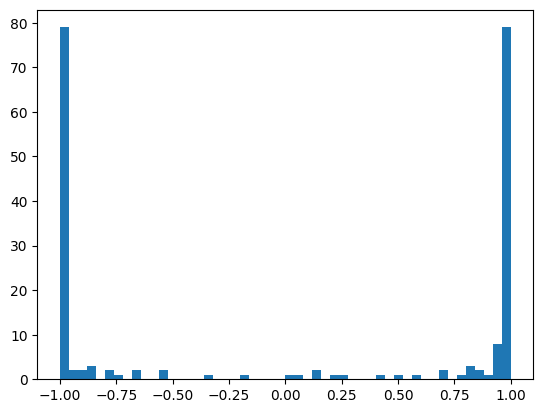

In [16]:
plt.hist(h.view(-1).tolist(), 50)

The tanh is very "active". Meaning that it is squashing alot of the values down to $1$ and $-1$

(array([  1.,   0.,   0.,   0.,   1.,   2.,   4.,   4.,   7.,  11.,  14.,
         24.,  28.,  20.,  45.,  44.,  98.,  84., 125., 160., 228., 263.,
        241., 314., 342., 424., 520., 493., 416., 345., 339., 370., 286.,
        258., 217., 130., 128., 136.,  87.,  61.,  35.,  30.,  18.,  23.,
          7.,   8.,   3.,   4.,   0.,   2.]),
 array([-28.80403137, -27.74016048, -26.6762896 , -25.61241871,
        -24.54854782, -23.48467693, -22.42080605, -21.35693516,
        -20.29306427, -19.22919338, -18.16532249, -17.10145161,
        -16.03758072, -14.97370983, -13.90983894, -12.84596806,
        -11.78209717, -10.71822628,  -9.65435539,  -8.5904845 ,
         -7.52661362,  -6.46274273,  -5.39887184,  -4.33500095,
         -3.27113007,  -2.20725918,  -1.14338829,  -0.0795174 ,
          0.98435349,   2.04822437,   3.11209526,   4.17596615,
          5.23983704,   6.30370792,   7.36757881,   8.4314497 ,
          9.49532059,  10.55919147,  11.62306236,  12.68693325,
         13.750804

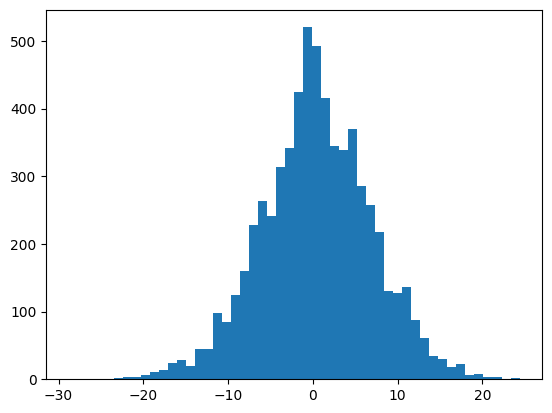

In [17]:
plt.hist(hpreact.view(-1).tolist(), 50)

This is the chart of the pre-activations, i.e. before tanh is applied.

### Why is 1s and -1s so bad?
Recall how we implemented tanh's backprop in micrograd as the following equation:

`self.grad += (1 - t**2) * out.grad`, where t = the value after tanh is applied.

So what happens when t = 1 or -1? Then self.grad is 0. Intuitively, it makes sense. Since we are at the tail end of the tanh, changing the input won't noticeably change the output. 

We essentially make out.grad completely useless. Look at the graphs above, and you can see why this may be an issue.

Look at the graph below for another visual. Each white square represents a gradient getting destroyed (t = 1 or -1).

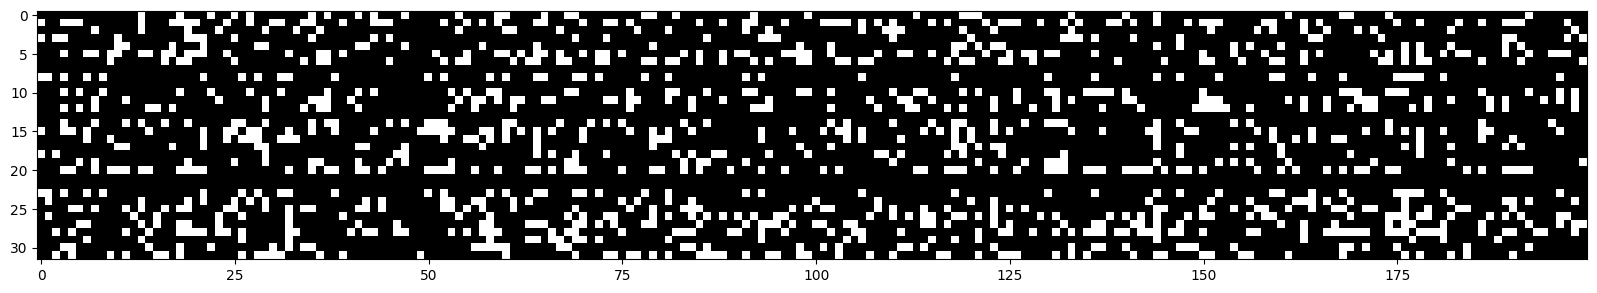

In [23]:
plt.figure(figsize=(20,10))
plt.imshow(h.abs() > 0.99, cmap='gray', interpolation='nearest')

This visualization provides some key information. If an entire column was white, then we would have a "dead neuron". Basically, the neuron will never learn and change.

This is true for any non-linear activation function with a "flat" end.

In [20]:
neuron_count = 200
embedding_dimension = 10
inputs = embedding_dimension * block_size # because the neural net always takes 3 inputs, so we multiply by 3 for inputs towards the hidden layer

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size,embedding_dimension), generator=g) # 10 dimensional embeddings
W1 = torch.randn((inputs,neuron_count),           generator=g) * 0.2  # saturates tanh
b1 = torch.randn(neuron_count,                    generator=g) * 0.01 # makes hpreact closer to 0       
W2 = torch.randn((neuron_count,vocab_size),       generator=g) * 0.01 # don't set weights to 0
b2 = torch.randn(vocab_size,                      generator=g) * 0 # adding a random b2 at initilization isn't useful
parameters = [C, W1, b1, W2, b2]

print(sum(p.nelement() for p in parameters)) # number of parameters in total

for p in parameters:
    p.requires_grad = True

11897


In [22]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    # mini batch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
    
    # forward pass
    emb = C[Xb]                        # embed the characters into vectors
    embcat = emb.view(emb.shape[0], -1)     # concatenate the vectors
    hpreact = embcat @ W1 + b1              # hidden layer pre-activation
    h = torch.tanh(hpreact)                 # hidden layer
    logits = h @ W2 + b2                    # output layer
    loss = F.cross_entropy(logits, Yb) # loss function
    
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

      0/ 200000: 3.3135
  10000/ 200000: 2.1648
  20000/ 200000: 2.3061
  30000/ 200000: 2.4541
  40000/ 200000: 1.9787
  50000/ 200000: 2.2930
  60000/ 200000: 2.4232
  70000/ 200000: 2.0680
  80000/ 200000: 2.3095
  90000/ 200000: 2.1207
 100000/ 200000: 1.8269
 110000/ 200000: 2.2045
 120000/ 200000: 1.9797
 130000/ 200000: 2.3946
 140000/ 200000: 2.1001
 150000/ 200000: 2.1948
 160000/ 200000: 1.8619
 170000/ 200000: 1.7809
 180000/ 200000: 1.9673
 190000/ 200000: 1.8295


(array([ 959.,  218.,  145.,  120.,  105.,  100.,   72.,   85.,   75.,
          70.,   69.,   74.,   69.,   68.,   76.,   65.,   49.,   77.,
          49.,  105.,   90.,   91.,  107.,   87.,   92.,  124.,  133.,
         101.,  101.,  120.,   71.,   86.,   60.,   73.,   44.,   73.,
          55.,   59.,   37.,   63.,   64.,   59.,   81.,   76.,   78.,
         133.,  130.,  143.,  261., 1058.]),
 array([-1.  , -0.96, -0.92, -0.88, -0.84, -0.8 , -0.76, -0.72, -0.68,
        -0.64, -0.6 , -0.56, -0.52, -0.48, -0.44, -0.4 , -0.36, -0.32,
        -0.28, -0.24, -0.2 , -0.16, -0.12, -0.08, -0.04,  0.  ,  0.04,
         0.08,  0.12,  0.16,  0.2 ,  0.24,  0.28,  0.32,  0.36,  0.4 ,
         0.44,  0.48,  0.52,  0.56,  0.6 ,  0.64,  0.68,  0.72,  0.76,
         0.8 ,  0.84,  0.88,  0.92,  0.96,  1.  ]),
 <BarContainer object of 50 artists>)

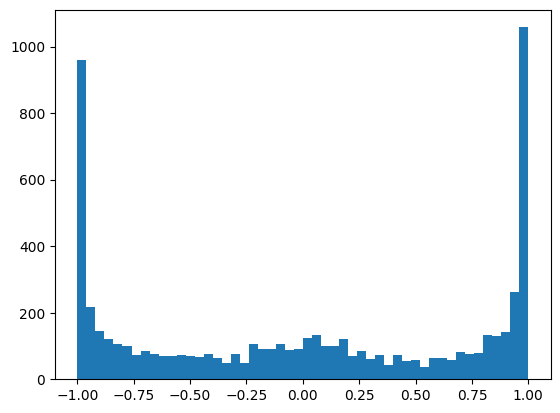

In [24]:
plt.hist(h.view(-1).tolist(), 50)

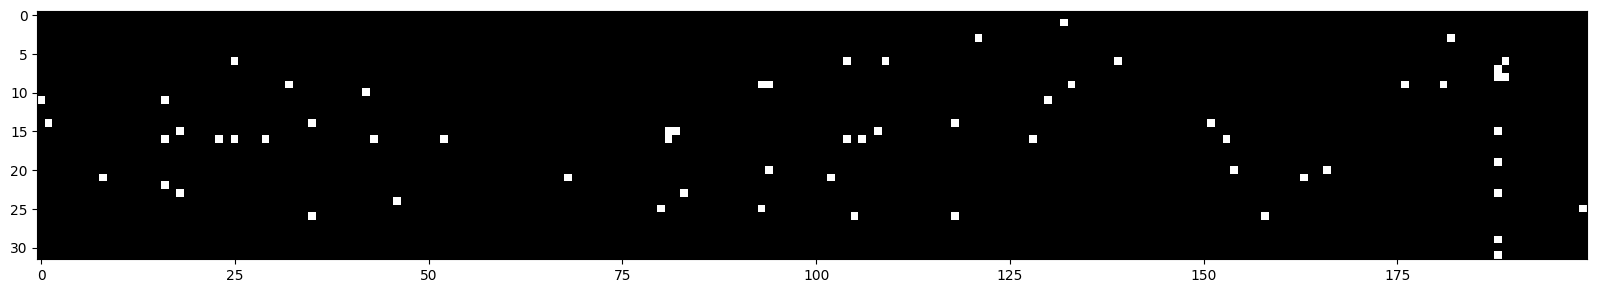

In [45]:
plt.figure(figsize=(20,10))
plt.imshow(h.abs() > 0.99, cmap='gray', interpolation='nearest')

In [25]:
@torch.no_grad() # this decorator disables gradient tracking, just makes it more efficient
def split_loss(split):
    x, y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte),
    }[split]
    emb = C[x]                           # (N, block_size, n_embd)
    embcat = emb.view(emb.shape[0], -1)  # concat into (N, block_size, n_embd)
    h = torch.tanh(embcat @ W1 + b1)     # (N, n_hidden)
    logits = h @ W2 + b2                 # (N, vocab_size)
    loss = F.cross_entropy(logits, y) 
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.0355966091156006
val 2.1026782989501953


Our val is 2.10, compared to 2.13. Much better. 

This may not seem like a lot, which is true because of how small our network is, when the Neural Network expands, like 50 layers, then these optimizations will be a huge help to their training. If your initialization is terrible, then it's possible for the network to never learn. 

As your network gets more complex and deeper the less forgiving it is to these errors. 

## How do we come up with the init values?
How do we come up with the values we used to squash down the initialization? (0.2, 0.01, ...)

tensor(-0.0033) tensor(0.9916)
tensor(-0.0011) tensor(0.9858)


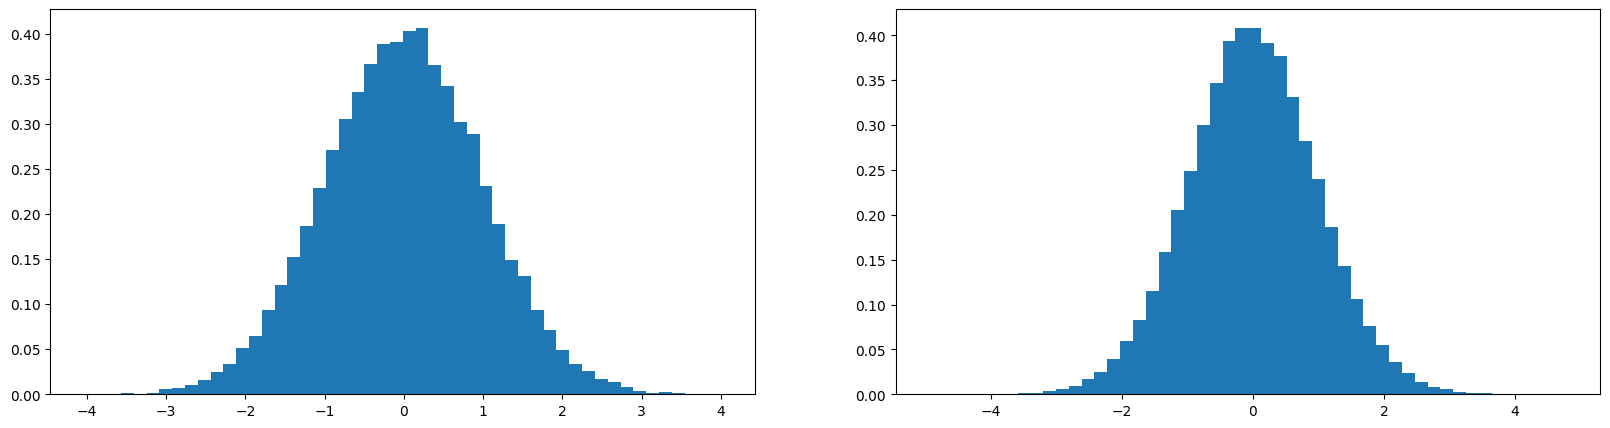

In [26]:
x = torch.randn(1000, 30)
w = torch.randn(30, 200) / 30**0.5
y = x @ w
print(x.mean(), x.std())
print(y.mean(), y.std())
plt.figure(figsize=(20, 5))
plt.subplot(121)
plt.hist(x.view(-1).tolist(), 50, density=True);
plt.subplot(122)
plt.hist(y.view(-1).tolist(), 50, density=True);

Notice how the standard deviation in the second graph is different than the first. We do not want that to happen when we activate a neuron (`y = x @ w`). We want it to be roughly the same.

Try multiplying `w` by a number. The higher we go, the more spread out the standard deviation (the greater the tensor value), the lower we go, the more squished the standard deviation (the lower the tensor value). Let's come up with a number such that the before and after tensor value are the exact same. 

Mathematically, it would be the division of the `fan_in`(number of inputs) by the square root.

Back then, the initialization of a neural net was vital, because if it was initialized improperly then the entire net may fail. Nowadays, we have more modern ways of initialization, where our neural nets won't be as finnicky. 

Karpathy suggests to just divide by the square root of `fan_in`

In [27]:
(torch.randn(10000) * 0.2).std()

tensor(0.1994)

Notice how whatever we multiply, that becomes the standard deviation (this is what we are doing when we squash down our init values!).

So, let us multiply it by the tanh gain:

In [28]:
(5/3) / (30**0.5)

0.3042903097250923

Thus, our standard deviation should be:

In [29]:
neuron_count = 200
embedding_dimension = 10
inputs = embedding_dimension * block_size # because the neural net always takes 3 inputs, so we multiply by 3 for inputs towards the hidden layer

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size,embedding_dimension), generator=g) # 10 dimensional embeddings
W1 = torch.randn((inputs,neuron_count),           generator=g) * (5/3) / (inputs**0.5)  # saturates tanh
b1 = torch.randn(neuron_count,                    generator=g) * 0.01 # makes hpreact closer to 0       
W2 = torch.randn((neuron_count,vocab_size),       generator=g) * 0.01 # don't set weights to 0
b2 = torch.randn(vocab_size,                      generator=g) * 0 # adding a random b2 at initilization isn't useful
parameters = [C, W1, b1, W2, b2]

print(sum(p.nelement() for p in parameters)) # number of parameters in total

for p in parameters:
    p.requires_grad = True

11897


In [30]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    # mini batch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
    
    # forward pass
    emb = C[Xb]                        # embed the characters into vectors
    embcat = emb.view(emb.shape[0], -1)     # concatenate the vectors
    hpreact = embcat @ W1 + b1              # hidden layer pre-activation
    h = torch.tanh(hpreact)                 # hidden layer
    logits = h @ W2 + b2                    # output layer
    loss = F.cross_entropy(logits, Yb) # loss function
    
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

      0/ 200000: 3.3179
  10000/ 200000: 2.1910
  20000/ 200000: 2.3270
  30000/ 200000: 2.5396
  40000/ 200000: 1.9468
  50000/ 200000: 2.3331
  60000/ 200000: 2.3852
  70000/ 200000: 2.1173
  80000/ 200000: 2.3159
  90000/ 200000: 2.2010
 100000/ 200000: 1.8591
 110000/ 200000: 2.0881
 120000/ 200000: 1.9389
 130000/ 200000: 2.3913
 140000/ 200000: 2.0949
 150000/ 200000: 2.1458
 160000/ 200000: 1.7824
 170000/ 200000: 1.7249
 180000/ 200000: 1.9751
 190000/ 200000: 1.8614


In [63]:
@torch.no_grad() # this decorator disables gradient tracking, just makes it more efficient
def split_loss(split):
    x, y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte),
    }[split]
    emb = C[x]                           # (N, block_size, n_embd)
    embcat = emb.view(emb.shape[0], -1)  # concat into (N, block_size, n_embd)
    h = torch.tanh(embcat @ W1 + b1)     # (N, n_hidden)
    logits = h @ W2 + b2                 # (N, vocab_size)
    loss = F.cross_entropy(logits, y) 
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.0376641750335693
val 2.106989622116089


## Summary (so far...):
Orginal (before any changes (makemore pt1)): \
`train 2.12` \
`val   2.16`

Fix softmax confidently wrong: \
`train 2.069589138031006` \
`val   2.1310746669769287`

Fix tanh layer too saturated at init: \
`train 2.0357086658477783` \
`val   2.102949380874634` 

Fixing the init scale: \
`train 2.0376641750335693` \
`val 2.106989622116089`

Fixing the init scale basically did nothing. All we did was essentially get rid of magic numbers, allowing it to be more readable.

## Batch Normalization

Makes it possible to train deep neural networks quite reliably.

Recall that we want the tanh pre-activation to be within 1 standard deviation of 0 at initialization (if close to 0, then tanh inactive. if close to 1, then tanh too saturated). So why don't we just normalize the hidden layer pre-activation to be within 1 std deviation? That is the basic idea of Batch Normalization.

Notice that the mean + standard deviation are perfectly differentiable.

At first, if we were to only normalize the hidden layers, then that would defeat the purpose of the neural net "learning", since it would just forcibly standardize everything. We introduce `bngain` batch-normalization gain and `bnbias` batch-normalization bias, to allow for the "standardization" to be more flexible with the neural network.

In [41]:
neuron_count = 200
embedding_dimension = 10
inputs = embedding_dimension * block_size # because the neural net always takes 3 inputs, so we multiply by 3 for inputs towards the hidden layer

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size,embedding_dimension), generator=g) # 10 dimensional embeddings
W1 = torch.randn((inputs,neuron_count),           generator=g) * (5/3) / (inputs**0.5)  # saturates tanh
b1 = torch.randn(neuron_count,                    generator=g) * 0.01 # makes hpreact closer to 0       
W2 = torch.randn((neuron_count,vocab_size),       generator=g) * 0.01 # don't set weights to 0
b2 = torch.randn(vocab_size,                      generator=g) * 0 # adding a random b2 at initilization isn't useful

bngain = torch.ones((1, neuron_count))
bnbias = torch.zeros((1, neuron_count))

parameters = [C, W1, b1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters)) # number of parameters in total

for p in parameters:
    p.requires_grad = True

12297


In [46]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    # mini batch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
    
    # forward pass
    emb = C[Xb]                        # embed the characters into vectors
    embcat = emb.view(emb.shape[0], -1)     # concatenate the vectors
    hpreact = embcat @ W1 + b1              # hidden layer pre-activation
    hpreact = bngain * (hpreact - hpreact.mean(0, keepdim=True)) / hpreact.std(0, keepdim=True) + bnbias # will be exactly gaussian
    h = torch.tanh(hpreact)                 # hidden layer
    logits = h @ W2 + b2                    # output layer
    loss = F.cross_entropy(logits, Yb) # loss function
    
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

      0/ 200000: 2.2236
  10000/ 200000: 1.7011
  20000/ 200000: 2.5979
  30000/ 200000: 2.5349
  40000/ 200000: 2.2926
  50000/ 200000: 2.4474
  60000/ 200000: 2.2451
  70000/ 200000: 1.9564
  80000/ 200000: 2.3291
  90000/ 200000: 2.2640
 100000/ 200000: 1.8879
 110000/ 200000: 2.1015
 120000/ 200000: 1.9611
 130000/ 200000: 2.3923
 140000/ 200000: 1.9997
 150000/ 200000: 2.4829
 160000/ 200000: 2.1175
 170000/ 200000: 2.0989
 180000/ 200000: 1.9290
 190000/ 200000: 2.1549


In [48]:
@torch.no_grad() # this decorator disables gradient tracking, just makes it more efficient
def split_loss(split):
    x, y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte),
    }[split]
    emb = C[x]                           # (N, block_size, n_embd)
    embcat = emb.view(emb.shape[0], -1)  # concat into (N, block_size, n_embd)
    hpreact = embcat @ W1 + b1
    hpreact = bngain * (hpreact - hpreact.mean(0, keepdim=True)) / hpreact.std(0, keepdim=True) + bnbias # will be exactly gaussian
    h = torch.tanh(hpreact)     # (N, n_hidden)
    logits = h @ W2 + b2                 # (N, vocab_size)
    loss = F.cross_entropy(logits, y) 
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.050631284713745
val 2.0970404148101807


## Summary (so far...):
Orginal (before any changes (makemore pt1)): \
`train 2.12` \
`val   2.16`

Fix softmax confidently wrong: \
`train 2.069589138031006` \
`val   2.1310746669769287`

Fix tanh layer too saturated at init: \
`train 2.0357086658477783` \
`val   2.102949380874634` 

Fixing the init scale: \
`train 2.0376641750335693` \
`val 2.106989622116089`

Adding Batch Normalization layer: \
`train 2.050631284713745` \
`val 2.0970404148101807` 


Notice that the Batch Normalization isn't doing much, because our Neural Network is very simple. But once you have a much deeper neural network, you cannot expect W to be able to tune the scales of the weight matrices such that all the neurons across the network are roughly gaussian. Comparetively, it is much easier to sprinkle batch normalization layers throughout the neural net. 

The stability provided by batch normalization comes at a terrible cost. If you look at the calculations for `hpreact`, notice that the entire batch normalization is sent in the forward pass and back propagation. This means that each neuron experiences a "jitter", where it tries to fit into every single datapoint within the batch. Turns out, that this isn't all too bad for the model, and is actually quite good. Essentially it introduces a little bit of entropy, which is a form of data augmentation, making it harder for the neural net to overfit. 

Since our neural net expects batches now, how do we provide a single input to receive a prediction? (How do we sample now?)

In [53]:
neuron_count = 200
embedding_dimension = 10
inputs = embedding_dimension * block_size # because the neural net always takes 3 inputs, so we multiply by 3 for inputs towards the hidden layer

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size,embedding_dimension), generator=g) # 10 dimensional embeddings
W1 = torch.randn((inputs,neuron_count),           generator=g) * (5/3) / (inputs**0.5)  # saturates tanh
#b1 = torch.randn(neuron_count,                    generator=g) * 0.01 # makes hpreact closer to 0       
W2 = torch.randn((neuron_count,vocab_size),       generator=g) * 0.01 # don't set weights to 0
b2 = torch.randn(vocab_size,                      generator=g) * 0 # adding a random b2 at initilization isn't useful

bngain = torch.ones((1, neuron_count))
bnbias = torch.zeros((1, neuron_count))
bnmean_running = torch.zeros((1, neuron_count))
bnstd_running = torch.ones((1, neuron_count))

parameters = [C, W1, b1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters)) # number of parameters in total

for p in parameters:
    p.requires_grad = True

12297


In [54]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    # mini batch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
    
    # forward pass
    emb = C[Xb]                        # embed the characters into vectors
    embcat = emb.view(emb.shape[0], -1)     # concatenate the vectors
    # Linear Layer
    hpreact = embcat @ W1 #+ b1              # hidden layer pre-activation
    # BatchNorm Layer
    # --------------------------------------------------
    bnmeani = hpreact.mean(0, keepdim=True)
    bnstdi = hpreact.std(0, keepdim=True)
    hpreact = bngain * (hpreact - bnmeani) / bnstdi + bnbias # will be exactly gaussian

    # keeping track of typical mean + standard deviation
    with torch.no_grad():
        bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
        bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi
    # --------------------------------------------------
    # Non-linearity
    h = torch.tanh(hpreact)                 # hidden layer
    logits = h @ W2 + b2                    # output layer
    loss = F.cross_entropy(logits, Yb) # loss function
    
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

      0/ 200000: 3.3147
  10000/ 200000: 2.1984
  20000/ 200000: 2.3375
  30000/ 200000: 2.4359
  40000/ 200000: 2.0119
  50000/ 200000: 2.2595
  60000/ 200000: 2.4775
  70000/ 200000: 2.1020
  80000/ 200000: 2.2788
  90000/ 200000: 2.1862
 100000/ 200000: 1.9474
 110000/ 200000: 2.3010
 120000/ 200000: 1.9837
 130000/ 200000: 2.4523
 140000/ 200000: 2.3839
 150000/ 200000: 2.1987
 160000/ 200000: 1.9733
 170000/ 200000: 1.8668
 180000/ 200000: 1.9973
 190000/ 200000: 1.8347


In [61]:
# calibrate the batch norm at the end of training
# explicit stage of normalization
with torch.no_grad():
    # pass the training set through
    emb = C[Xtr]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 + b1
    # measure the mean/std over the entire training set
    bnmean = hpreact.mean(0, keepdim=True)
    bnstd = hpreact.std(0, keepdim=True)

In [62]:
@torch.no_grad() # this decorator disables gradient tracking, just makes it more efficient
def split_loss(split):
    x, y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte),
    }[split]
    emb = C[x]                           # (N, block_size, n_embd)
    embcat = emb.view(emb.shape[0], -1)  # concat into (N, block_size, n_embd)
    hpreact = embcat @ W1 + b1
    hpreact = bngain * (hpreact - bnmean_running) / bnstd_running + bnbias # will be exactly gaussian
    h = torch.tanh(hpreact)     # (N, n_hidden)
    logits = h @ W2 + b2                 # (N, vocab_size)
    loss = F.cross_entropy(logits, y) 
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.06659197807312
val 2.1050572395324707


Identical result, and now we gain the ability to foward a single example. 

When using batch normalization, 2 things to consider:
1. In the calculation for `hpreact`, you should add a very small epsilon to prevent division by 0
2. The bias in `hpreact = embcat @ W1 + b1` is useless. If you were to print it out, you would get 0. So just comment it out.

Karpathy says that no one really likes the Batch Normalization layer, because it causes too many bugs. Intuitively, it is because it couples all the training data throughout the Neural Network. 

"Try to avoid it as much as possible". Use group normalization or layer normalization. 

# PyTorch-ifying the code

In [170]:
# Let's train a deeper network

# Representing pytorch's Linear Layer
class Linear:
    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn((fan_in, fan_out), generator=g) / fan_in**0.5 # kanming init
        self.bias = torch.zeros(fan_out) if bias else None

    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None: 
            self.out += self.bias
        return self.out

    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])

# Representing pytorch's torch.nn BatchNorm1d
class BatchNorm1d:
    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        # parameters (trained with backprop)
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        # buffers (trained with a running 'momentum update')
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)

    def __call__(self, x):
        # calculate the forward pass
        if self.training:
            xmean = x.mean(0, keepdim=True) # batch mean
            xvar = x.var(0, keepdim=True) # batch variance
        else:
            xmean = self.running_mean
            xvar = self.running_var

        xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
        self.out = self.gamma * xhat + self.beta # used for statistics. pytorch would not have this
        # update the buffers
        if self.training:
            # tracks running stats
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
        return self.out

    def parameters(self):
        return [self.gamma, self.beta]

class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    def parameters(self):
        return []

# Because these are layers, it becomes easy to build deeper networks

n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 100 # the number of neurons in the hidden layer of the MLP
g = torch.Generator().manual_seed(2147483647)

C = torch.randn((vocab_size, n_embd), generator=g)
layers = [
    Linear(n_embd * block_size, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(           n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(           n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(           n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(           n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(           n_hidden, vocab_size), BatchNorm1d(vocab_size),
]

with torch.no_grad():
    # last layer: make less confident
    layers[-1].gamma *= 0.1
    # all other layers: apply gain
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weight *= 5.0 #5/3

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
    p.requires_grad = True

47551


In [171]:
max_steps = 200000
batch_size = 32
lossi = []
updatetodataratio = []

for i in range(max_steps):
    # mini batch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
    
    # forward pass
    emb = C[Xb]                        # embed the characters into vectors
    x = emb.view(emb.shape[0], -1)     # concatenate the vectors
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, Yb) # loss function
    
    # backward pass
    for layer in layers:
        layer.out.retain_grad() # AFTER_DEBUG: would take out retain_graph
    for p in parameters:
        p.grad = None
    loss.backward()

    # stochastic gradient descent
    lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

    with torch.no_grad():
        updatetodataratio.append([(lr*p.grad.std() / p.data.std()).log10().item() for p in parameters])
    
    if i >= 1000:
        break 

      0/ 200000: 3.2870


layer 2 (      Tanh): mean -0.00, std 0.63, saturated: 2.56%
layer 5 (      Tanh): mean +0.00, std 0.63, saturated: 2.44%
layer 8 (      Tanh): mean -0.00, std 0.64, saturated: 2.25%
layer 11 (      Tanh): mean -0.00, std 0.64, saturated: 2.31%
layer 14 (      Tanh): mean +0.01, std 0.64, saturated: 2.53%


Text(0.5, 1.0, 'activation distribution')

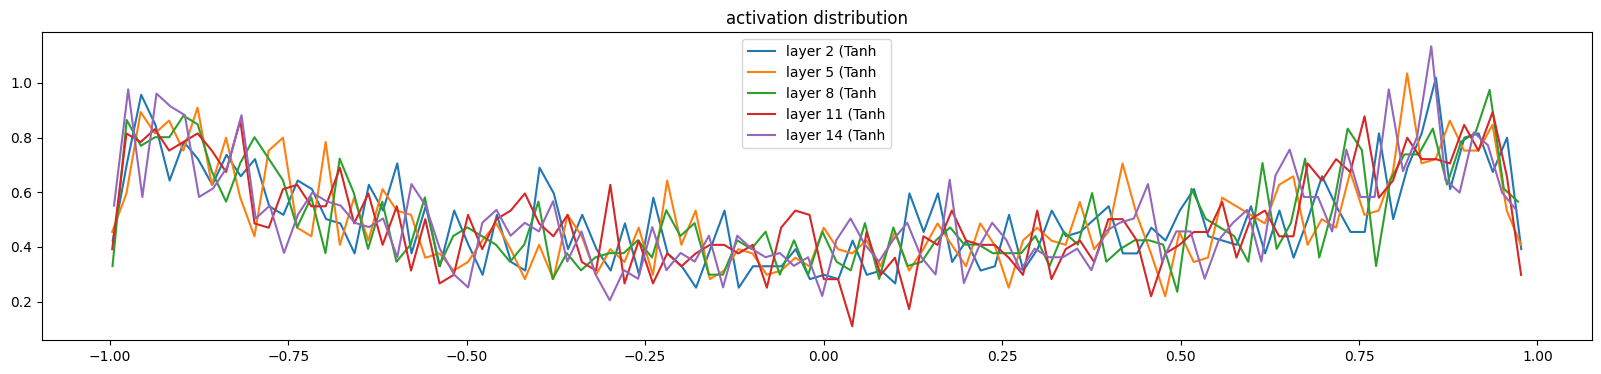

In [172]:
# visualize histograms
plt.figure(figsize=(20,4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exlucde the output layer
    if isinstance(layer, Tanh):
        t = layer.out
        print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__}')

plt.legend(legends);
plt.title('activation distribution')

The above graph tells us how many tensors in a layer takes on the value in the x-axis. We multiply by some gain, to fight against how much squashing Tanh does to our tensors.

layer 2 (      Tanh): mean -0.000000, std 3.890700e-03
layer 5 (      Tanh): mean +0.000000, std 3.427125e-03
layer 8 (      Tanh): mean +0.000000, std 3.132342e-03
layer 11 (      Tanh): mean -0.000000, std 2.841915e-03
layer 14 (      Tanh): mean -0.000000, std 2.471204e-03


Text(0.5, 1.0, 'gradient distribution')

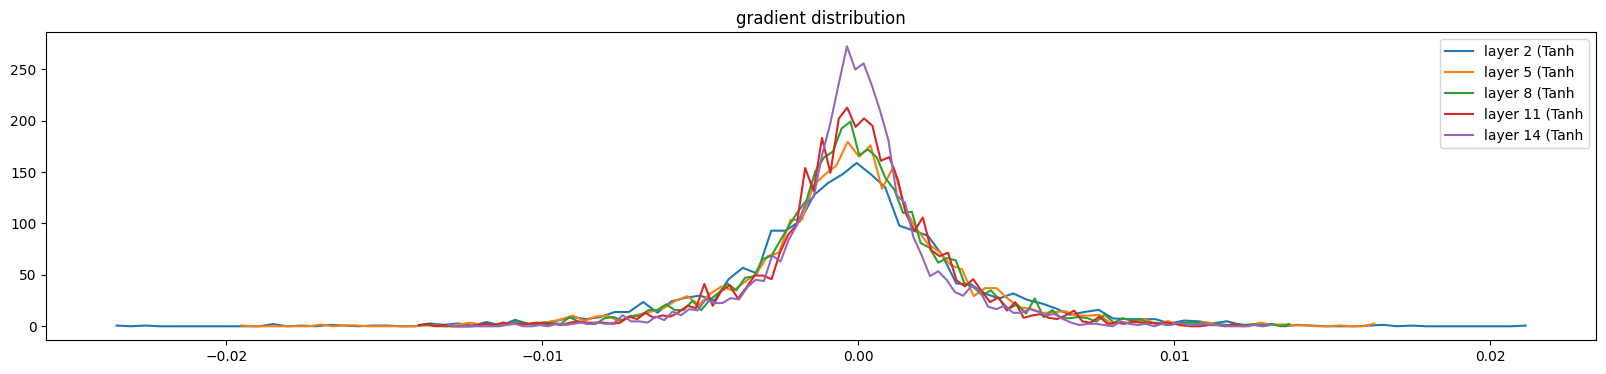

In [173]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
    if isinstance(layer, Tanh):
        t = layer.out.grad
        print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__}')

plt.legend(legends);
plt.title('gradient distribution')

weight   (27, 10) | mean -0.000000 | std 7.996252e-03 | grad:data ratio 7.988940e-03
weight  (30, 100) | mean +0.000040 | std 2.756465e-03 | grad:data ratio 2.946202e-03
weight (100, 100) | mean +0.000025 | std 2.622191e-03 | grad:data ratio 5.261245e-03
weight (100, 100) | mean +0.000005 | std 2.396152e-03 | grad:data ratio 4.757303e-03
weight (100, 100) | mean -0.000004 | std 2.191799e-03 | grad:data ratio 4.369890e-03
weight (100, 100) | mean -0.000007 | std 1.964616e-03 | grad:data ratio 3.913206e-03
weight  (100, 27) | mean -0.000026 | std 3.231946e-03 | grad:data ratio 6.537119e-03


Text(0.5, 1.0, 'weights gradient distribution')

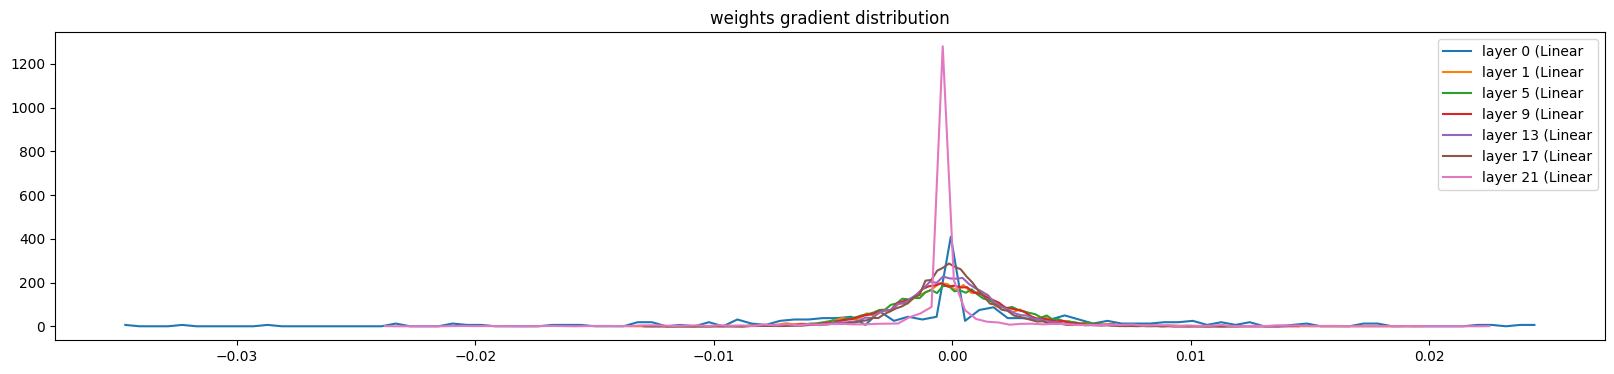

In [174]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, p in enumerate(parameters): # note: exclude the output layer
    t = p.grad
    if p.ndim == 2:
        print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__}')

plt.legend(legends);
plt.title('weights gradient distribution')

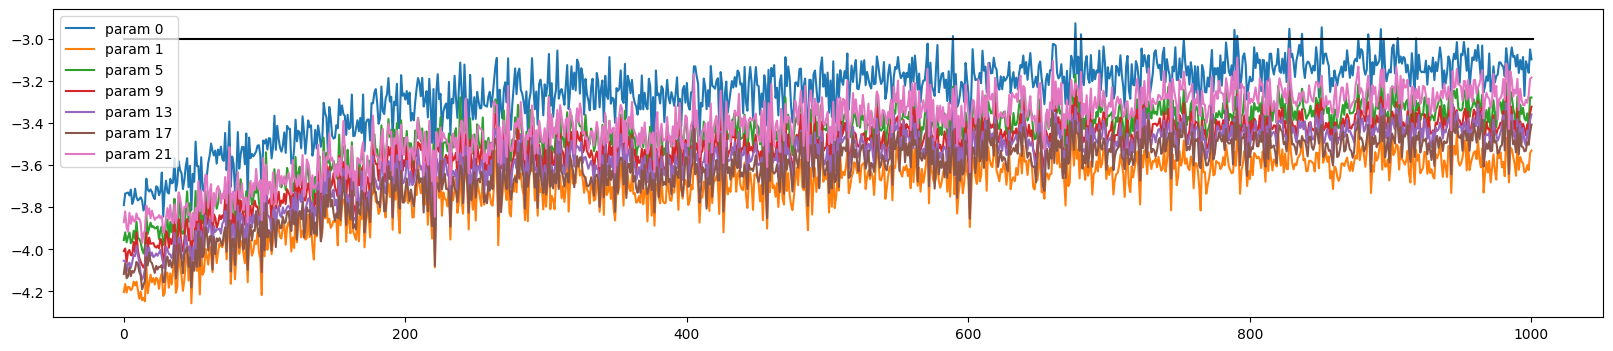

In [175]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, p in enumerate(parameters): # note: exclude the output layer
    if p.ndim == 2:
        plt.plot([updatetodataratio[j][i] for j in range(len(updatetodataratio))])
        legends.append('param %d' % i)
plt.plot([0, len(updatetodataratio)], [-3, -3], 'k') # these ratios should be ^1e-3, indicate on plot
plt.legend(legends);

If the lines are showing anything below -3.0, then you know your learning rate is too low.

Right now, our learning rate is a bit on the higher side, since some of the updates are above -3.0.

Adding in the Batch Normalization to in between the layers makes all the graphs very good. The advantage is that the gain we put no longer has to be a specific number. We can set it to more or less any number, and the graphs will more or less remain the same, besides the update rate. In that case, you may have to change the learning rate.

## Summary
What we have done is simply Pytorch-ifying our code. Karpathy has made it such that our code is nearly identical to Pytorch's. As well, he has shown us 4 useful graphs for displaying how our model is performing. 

What we have not done is further optimizing it. At this point, our model is bottlenecked by our very limited context length (recall that it's 3 characters). We will look into greater context lengths in future parts.